In [9]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import utils
from utils import plot_nnpredict_45

import keras
from tensorflow.keras.callbacks import EarlyStopping

from pickle import dump
import re

In [2]:
seed = 1986436

rand = np.random.RandomState(seed)
mInt = (1 << 15)  # bitshift operator
MInt = (1 << 16)  # \equiv 2**16

log_n = 14
NUM = (1 << log_n)

EPS = 0.04

outputPrfx = "full"
challengePrfx = "challenge"
targetPrfx = "target"

bounds = { "T":      [6./12., 2.00]
         , "Sgma":   [ .15  ,  .80]
         , "Strike": [ .60  , 1.20]
         }

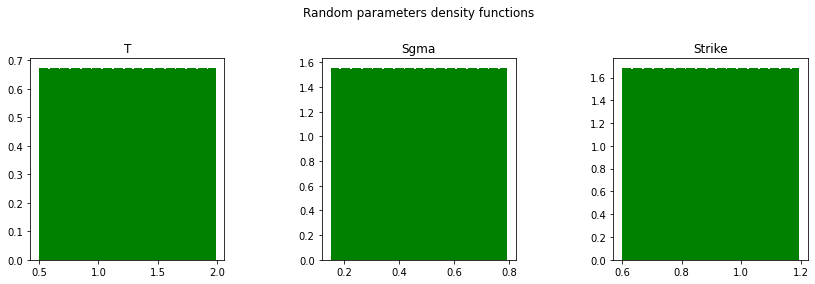

In [3]:
xDF = utils.lhs_sampling(rand, NUM, bounds=bounds)
utils.histo_params( xDF, title = "Random parameters density functions")

In [4]:
yDF = utils.gen_BnS(NUM, xDF)

Exercise for you: Try to understand what gen_BnS is doing

Tips:
- Put Call parity:  $P - C = Ke^{-rT} - S_0$
- P = $N(-d_{-})Ke^{-rT}-N(-d_{+})S_{0}$ where $N(x)$ is the normal cumulative distribution function 
- $d_{+}=\frac {1}{\sigma {\sqrt {T}}}[\ln({\frac {S_{0}}{K}})+(r+{\frac{\sigma ^{2}}{2}})T]$ , $d_{-}=d_{+}-\sigma \sqrt {T}$

In [5]:
yDF.head()

,T,Sgma,Strike,Price
0,1.364761,0.331404,1.189252,0.089697
1,1.163620,0.662474,0.994574,0.281103
2,1.906113,0.154344,0.763312,0.245732
3,1.072067,0.626253,0.732257,0.377908
4,1.477280,0.152361,0.734344,0.268786


In [6]:
train_set, test_set = train_test_split(yDF, test_size=0.25, random_state=rand.randint(mInt,MInt))   

<h3> add noise to prices in the train set

In [7]:
if EPS > 0.0: 
    train_set_pnoise = utils.add_noise(rand, train_set, EPS)
else:         
    train_set_pnoise = train_set

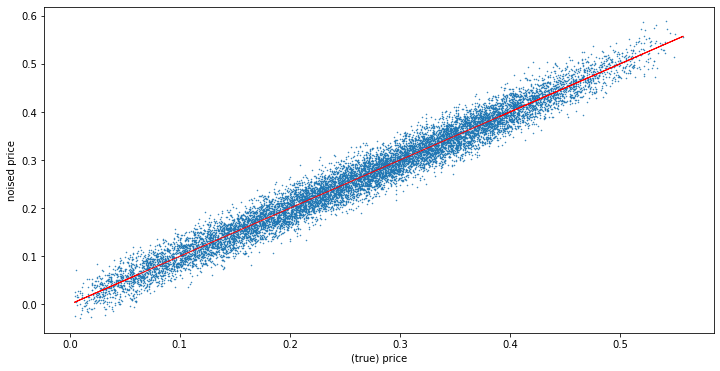

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.plot(train_set["Price"], train_set_pnoise["Price"], ".", markersize=1)
ax.plot(train_set["Price"], train_set["Price"], color='red', linewidth=1)
ax.set_xlabel("(true) price")
ax.set_ylabel("noised price")
plt.show()

In [17]:
y_train = train_set_pnoise["Price"]
x_train = train_set_pnoise.drop(columns="Price")

y_test = test_set["Price"]
x_test = test_set.drop(columns="Price")



In [18]:
scaler = StandardScaler().fit(x_train)

In [19]:
x_train_transform = scaler.transform(x_train)
x_test_transform = scaler.transform(x_test)

### Build the Neural Network

In [23]:
N_hiddenLayers = 2
N_nodes = 64
i = keras.layers.Input(shape=(3, ))
x = keras.layers.Dense(N_nodes, activation='relu')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='relu')(x)
    c += 1
x = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mse', optimizer='adam')

### Training 

In [26]:
LEN = len(x_train_transform)
patience = 50
N_epochs = 500

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=patience)

model.fit(x_train_transform, y_train, epochs=N_epochs, verbose=True, batch_size=LEN, validation_split=.25, 
          callbacks=[early_stopping])

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.1489 - val_loss: 0.1036
Epoch 2/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1036 - val_loss: 0.0685
Epoch 3/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0684 - val_loss: 0.0434
Epoch 4/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0431 - val_loss: 0.0272
Epoch 5/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0267 - val_loss: 0.0181
Epoch 6/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0175 - val_loss: 0.0145
Epoch 7/500
1/1 [==============================] - 0s 83ms/step - loss: 0.0138 - val_loss: 0.0145
Epoch 8/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0137 - val_loss: 0.0161
Epoch 9/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0153 - val_loss: 0.0178
Epoch 10/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0171 - val_loss: 0.0188
Epoch 11/500
1/1 [===

Epoch 84/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 85/500
1/1 [==============================] - 0s 80ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 86/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 87/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 88/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 89/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 90/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 91/500
1/1 [==============================] - 0s 74ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 92/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 93/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 94/5

1/1 [==============================] - 0s 74ms/step - loss: 6.5057e-04 - val_loss: 6.9515e-04
Epoch 163/500
1/1 [==============================] - 0s 80ms/step - loss: 6.4685e-04 - val_loss: 6.9145e-04
Epoch 164/500
1/1 [==============================] - 0s 69ms/step - loss: 6.4323e-04 - val_loss: 6.8788e-04
Epoch 165/500
1/1 [==============================] - 0s 78ms/step - loss: 6.3973e-04 - val_loss: 6.8443e-04
Epoch 166/500
1/1 [==============================] - 0s 85ms/step - loss: 6.3633e-04 - val_loss: 6.8109e-04
Epoch 167/500
1/1 [==============================] - 0s 84ms/step - loss: 6.3303e-04 - val_loss: 6.7787e-04
Epoch 168/500
1/1 [==============================] - 0s 48ms/step - loss: 6.2984e-04 - val_loss: 6.7475e-04
Epoch 169/500
1/1 [==============================] - 0s 67ms/step - loss: 6.2674e-04 - val_loss: 6.7174e-04
Epoch 170/500
1/1 [==============================] - 0s 80ms/step - loss: 6.2373e-04 - val_loss: 6.6883e-04
Epoch 171/500
1/1 [=======================

Epoch 238/500
1/1 [==============================] - 0s 67ms/step - loss: 5.3582e-04 - val_loss: 5.8798e-04
Epoch 239/500
1/1 [==============================] - 0s 65ms/step - loss: 5.3533e-04 - val_loss: 5.8754e-04
Epoch 240/500
1/1 [==============================] - 0s 49ms/step - loss: 5.3485e-04 - val_loss: 5.8712e-04
Epoch 241/500
1/1 [==============================] - 0s 68ms/step - loss: 5.3437e-04 - val_loss: 5.8671e-04
Epoch 242/500
1/1 [==============================] - 0s 69ms/step - loss: 5.3390e-04 - val_loss: 5.8629e-04
Epoch 243/500
1/1 [==============================] - 0s 59ms/step - loss: 5.3344e-04 - val_loss: 5.8589e-04
Epoch 244/500
1/1 [==============================] - 0s 76ms/step - loss: 5.3299e-04 - val_loss: 5.8549e-04
Epoch 245/500
1/1 [==============================] - 0s 81ms/step - loss: 5.3253e-04 - val_loss: 5.8510e-04
Epoch 246/500
1/1 [==============================] - 0s 85ms/step - loss: 5.3209e-04 - val_loss: 5.8472e-04
Epoch 247/500
1/1 [=========

Epoch 314/500
1/1 [==============================] - 0s 85ms/step - loss: 5.1321e-04 - val_loss: 5.6969e-04
Epoch 315/500
1/1 [==============================] - 0s 78ms/step - loss: 5.1304e-04 - val_loss: 5.6956e-04
Epoch 316/500
1/1 [==============================] - 0s 77ms/step - loss: 5.1287e-04 - val_loss: 5.6944e-04
Epoch 317/500
1/1 [==============================] - 0s 65ms/step - loss: 5.1270e-04 - val_loss: 5.6932e-04
Epoch 318/500
1/1 [==============================] - 0s 89ms/step - loss: 5.1253e-04 - val_loss: 5.6920e-04
Epoch 319/500
1/1 [==============================] - 0s 66ms/step - loss: 5.1236e-04 - val_loss: 5.6908e-04
Epoch 320/500
1/1 [==============================] - 0s 74ms/step - loss: 5.1219e-04 - val_loss: 5.6896e-04
Epoch 321/500
1/1 [==============================] - 0s 85ms/step - loss: 5.1202e-04 - val_loss: 5.6885e-04
Epoch 322/500
1/1 [==============================] - 0s 43ms/step - loss: 5.1185e-04 - val_loss: 5.6874e-04
Epoch 323/500
1/1 [=========

Epoch 390/500
1/1 [==============================] - 0s 67ms/step - loss: 5.0311e-04 - val_loss: 5.6303e-04
Epoch 391/500
1/1 [==============================] - 0s 57ms/step - loss: 5.0300e-04 - val_loss: 5.6298e-04
Epoch 392/500
1/1 [==============================] - 0s 74ms/step - loss: 5.0290e-04 - val_loss: 5.6291e-04
Epoch 393/500
1/1 [==============================] - 0s 75ms/step - loss: 5.0280e-04 - val_loss: 5.6285e-04
Epoch 394/500
1/1 [==============================] - 0s 86ms/step - loss: 5.0269e-04 - val_loss: 5.6279e-04
Epoch 395/500
1/1 [==============================] - 0s 55ms/step - loss: 5.0259e-04 - val_loss: 5.6273e-04
Epoch 396/500
1/1 [==============================] - 0s 73ms/step - loss: 5.0249e-04 - val_loss: 5.6267e-04
Epoch 397/500
1/1 [==============================] - 0s 62ms/step - loss: 5.0239e-04 - val_loss: 5.6261e-04
Epoch 398/500
1/1 [==============================] - 0s 91ms/step - loss: 5.0229e-04 - val_loss: 5.6255e-04
Epoch 399/500
1/1 [=========

Epoch 466/500
1/1 [==============================] - 0s 47ms/step - loss: 4.9698e-04 - val_loss: 5.5961e-04
Epoch 467/500
1/1 [==============================] - 0s 82ms/step - loss: 4.9692e-04 - val_loss: 5.5958e-04
Epoch 468/500
1/1 [==============================] - 0s 69ms/step - loss: 4.9686e-04 - val_loss: 5.5956e-04
Epoch 469/500
1/1 [==============================] - 0s 69ms/step - loss: 4.9680e-04 - val_loss: 5.5953e-04
Epoch 470/500
1/1 [==============================] - 0s 63ms/step - loss: 4.9674e-04 - val_loss: 5.5950e-04
Epoch 471/500
1/1 [==============================] - 0s 85ms/step - loss: 4.9668e-04 - val_loss: 5.5947e-04
Epoch 472/500
1/1 [==============================] - 0s 69ms/step - loss: 4.9661e-04 - val_loss: 5.5944e-04
Epoch 473/500
1/1 [==============================] - 0s 75ms/step - loss: 4.9655e-04 - val_loss: 5.5942e-04
Epoch 474/500
1/1 [==============================] - 0s 66ms/step - loss: 4.9649e-04 - val_loss: 5.5940e-04
Epoch 475/500
1/1 [=========

128/128 [==============================] - 0s 2ms/step


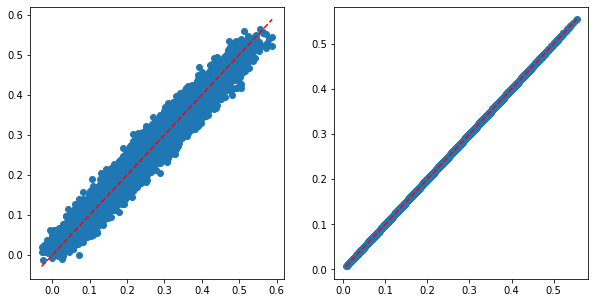

In [30]:
y_train_predict = model.predict(x_train_transform)
y_test_predict = model.predict(x_test_transform)

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].scatter(y_train, y_train_predict)
ax[0].plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], "--", c="red")

ax[1].scatter(y_test, y_test)
ax[1].plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], "--", c="red")

plt.show()

In [31]:
from sklearn.metrics import mean_squared_error

In [33]:
print(f"mse train : {mean_squared_error(y_train, y_train_predict)}")
print(f"mse test : {mean_squared_error(y_test, y_test_predict)}")

mse train : 0.0005109388641309338
mse test : 2.787182580335974e-05
